# Исследование эффективности дежурных операторов

В данном исследовании мы сравним эффективность работы дежурных операторов и терапевтов под запись в Виртуальной Клинике. Гипотеза: их эффективность примерно одинакова.

## Изучение данных

Для изучения есть два представления:
- `medical_telemed_case` - медицинские кейсы
- `medical_telemed_case_records` - услуги в медицинских кейсах

Для анализа мы соберём следующие два датасета:
- Онлайн-кейсы - кейсы категории "Телемед кейс" по врачам "Врач общей практики" или "Терапевт", отбросим кейсы "только спросить" и пациентов, у которых в программе только телемед, т.к. они помешают увидеть полную картину.
- Оффлайн-кейсы - все остальные кейсы, у которых категория не "Телемед кейс".

Импортируем библиотеки и загрузим данные.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from scipy import stats as st
from sqlalchemy import create_engine 

In [2]:
db_config = {
    'user': 'user', # имя пользователя
    'pwd': 'password', # пароль
    'host': 'server_ip',
    'port': 1000, # порт подключения
    'db': 'db' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 
engine = create_engine(connection_string) 

In [3]:
sql_online = """
select mtc.unique_case_id,
    mtc.patient_id,
	mtc.doctor_specialty_online,
	mtc.start_case,
	mtc.region ,
	mtc."Профиль" as profile,
	mtc.telemed_case_category as category,
	mtc.during_case as duration,
	mtc.sum_case_without_fot as loss,
	count(case when mtcr.category_title='Телемед консультация' then 1 end) as telemed_cnt,
	count(case when mtcr.category_title in ('Лабораторные исследования',
										'Инструментальные исследования',
										'Лечебные процедуры и манипуляции',
										'Восстановительная медицина') then 1 end) as analysis_cnt,
	count(case when mtcr.category_title='Приемы врачей' then 1 end) as offline_cnt,
	count(case when mtcr.category_title='Вызов врача на дом' then 1 end) as vnd_cnt,
	count(case when mtcr.category_title in ('Госпитализация','Дневной стационар') then 1 end) as hospital_cnt,
	count(case when mtcr.category_title is null then 1 end) as unknown_cnt
from etl_analytics.medical_telemed_case mtc 
	left join etl_analytics.medical_telemed_case_records mtcr 
		on mtc.unique_case_id = mtcr.unique_case_id 
where mtc.case_category = 'Телемед кейс' 
	and mtc.doctor_specialty_online in ('Врач общей практики','Терапевт')
	and mtc.is_just_ask_telemed = 0 and mtc.only_telemed_program = 0
group by 1,2,3,4,5,6,7,8,9
"""

In [4]:
sql_offline = """select mtc.unique_case_id,
    mtc.doctor_specialty_offline,
	mtc.start_case,
	mtc.region ,
	mtc."Профиль" as profile,
	mtc.during_case as duration,
	mtc.sum_case_without_fot as loss
from etl_analytics.medical_telemed_case mtc 
where case_category != 'Телемед кейс' 
and doctor_specialty_offline = 'Терапевт'
or doctor_specialty_offline = 'Врач общей практики'"""

In [5]:
data_online = pd.read_sql(sql_online, engine)
data_offline = pd.read_sql(sql_offline, engine)

Изучим полученные данные.

In [6]:
data_online.head()

,unique_case_id,patient_id,doctor_specialty_online,start_case,region,profile,category,duration,loss,telemed_cnt,analysis_cnt,offline_cnt,vnd_cnt,hospital_cnt,unknown_cnt
0,100004&Терапия&Заболевания дыхательных путей&1,100004,Терапевт,2021-12-01,Санкт-Петербург,Терапия,Только телемед без оффлайн,26,0.0,5,0,0,0,0,0
1,100018&Неврология&Другое и неуточненное (невро...,100018,Врач общей практики,2021-12-06,Санкт-Петербург,Неврология,Только телемед без оффлайн,1,0.0,1,0,0,0,0,0
2,100046&Травматология&0,100046,Врач общей практики,2022-04-19,Регионы,Травматология,Телемед+оффлайн прием,38,2766.0,3,0,1,0,0,1
3,100049&Терапия&Заболевания дыхательных путей&0,100049,Терапевт,2021-01-12,Регионы,Терапия,Только телемед без оффлайн,7,0.0,3,0,0,0,0,0
4,100078&Инфекции&0,100078,Врач общей практики,2021-10-17,Москва,Инфекции,Только телемед без оффлайн,1,0.0,1,0,0,0,0,0


In [7]:
data_offline.head()

,unique_case_id,doctor_specialty_offline,start_case,region,profile,duration,loss
0,100000&&0,Терапевт,2022-04-15,Регионы,None,5,1300.0
1,100004&Терапия&Заболевания дыхательных путей&0,Терапевт,2021-11-01,Санкт-Петербург,Терапия,9,4655.0
2,100004&Терапия&Заболевания дыхательных путей&2,Терапевт,2022-02-25,Санкт-Петербург,Терапия,1,1425.0
3,100004&Терапия&Заболевания дыхательных путей&3,Терапевт,2022-06-08,Санкт-Петербург,Терапия,15,5415.0
4,100004&Терапия&Профилактика&0,Терапевт,2021-07-13,Санкт-Петербург,Терапия,1,800.0


In [8]:
data_online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20186 entries, 0 to 20185
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unique_case_id           20186 non-null  object 
 1   patient_id               20186 non-null  int64  
 2   doctor_specialty_online  20186 non-null  object 
 3   start_case               20186 non-null  object 
 4   region                   20186 non-null  object 
 5   profile                  18166 non-null  object 
 6   category                 20186 non-null  object 
 7   duration                 20186 non-null  int64  
 8   loss                     20186 non-null  float64
 9   telemed_cnt              20186 non-null  int64  
 10  analysis_cnt             20186 non-null  int64  
 11  offline_cnt              20186 non-null  int64  
 12  vnd_cnt                  20186 non-null  int64  
 13  hospital_cnt             20186 non-null  int64  
 14  unknown_cnt           

In [9]:
data_offline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34122 entries, 0 to 34121
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   unique_case_id            34122 non-null  object 
 1   doctor_specialty_offline  34122 non-null  object 
 2   start_case                34122 non-null  object 
 3   region                    34122 non-null  object 
 4   profile                   28630 non-null  object 
 5   duration                  34122 non-null  int64  
 6   loss                      34122 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.8+ MB


## Предобработка данных

Заполним пропуски в `profile` значением `unknown`

In [10]:
data_online['profile'] = data_online['profile'].fillna('Unknown')
data_offline['profile'] = data_offline['profile'].fillna('Unknown')

Приведем даты к правильному формату.

In [11]:
data_online['start_case'] = pd.to_datetime(data_online['start_case'],
                                    format='%Y-%m-%d',
                                    errors='raise')
data_offline['start_case'] = pd.to_datetime(data_offline['start_case'],
                                    format='%Y-%m-%d',
                                    errors='raise')

Добавим поле `is_free`, которое будет принимать значение True, если кейс не принес никаких убытков.

In [12]:
data_online['is_free']=data_online['loss']==0

## Исследовательский анализ

### Онлайн и оффлайн кейсы

Изучим основные статистические показатели датасета с онлайн-кейсами.

In [13]:
data_online.describe()

,patient_id,duration,loss,telemed_cnt,analysis_cnt,offline_cnt,vnd_cnt,hospital_cnt,unknown_cnt
count,20186.000000,20186.000000,20186.000000,20186.000000,20186.000000,20186.000000,20186.000000,20186.0,20186.000000
mean,114291.505301,11.400030,1379.623614,1.151095,0.514267,0.207322,0.022937,0.0,0.047904
std,55694.846685,42.896465,4339.208169,0.612202,1.975229,0.658225,0.166917,0.0,0.323980
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,69725.250000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,111190.500000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,159821.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,222500.000000,538.000000,123806.190000,11.000000,36.000000,12.000000,3.000000,0.0,20.000000


In [49]:
data_offline.describe()

,duration,loss
count,33013.000000,33013.000000
mean,18.630691,3314.888405
std,59.881294,2767.990369
min,1.000000,0.000000
25%,1.000000,1400.000000
50%,1.000000,2300.000000
75%,8.000000,4260.000000
max,522.000000,15000.000000


Изучим распределение убытков в онлайн-кейсах, выкинув кейсы, где loss=0.

<AxesSubplot:>

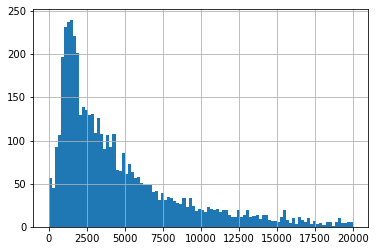

In [14]:
data_online['loss'].hist(bins=100,range=(1,20000))

Изучим распределение убытков в оффлайн-кейсах

<AxesSubplot:>

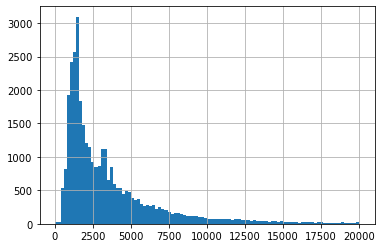

In [15]:
data_offline['loss'].hist(bins=100,range=(1,20000))

Проверим данные на выбросы, построив диаграммы размаха.

(0.0, 20000.0)

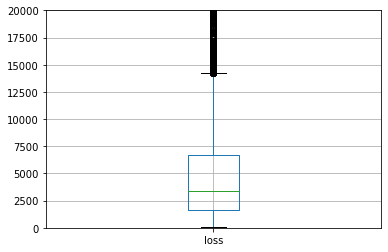

In [16]:
data_online[data_online['loss']>0].boxplot(column='loss')
plt.ylim(0, 20000) 

(0.0, 20000.0)

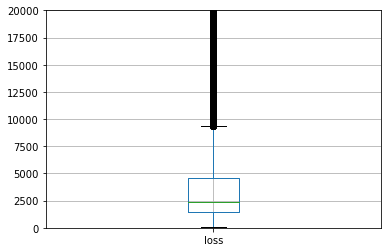

In [17]:
data_offline[data_offline['loss']>0].boxplot(column='loss')
plt.ylim(0, 20000) 

Отбросим выбросы в обоих датасетах.

In [18]:
data_online[data_online['loss']>15000]['loss'].count()

351

In [19]:
data_online = data_online[data_online['loss']<=15000]

In [20]:
data_offline[data_offline['loss']>15000]['loss'].count()

1109

In [21]:
data_offline = data_offline[data_offline['loss']<=15000]

Сравним длительность онлайн и оффлайн кейсов.

<AxesSubplot:>

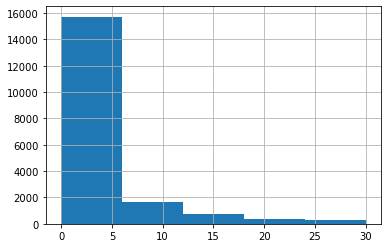

In [22]:
data_online['duration'].hist(bins=5,range=(0,30))

<AxesSubplot:>

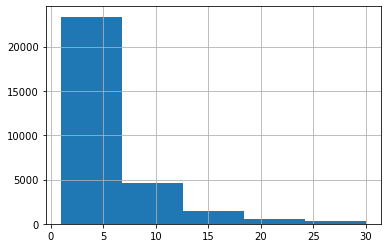

In [23]:
data_offline['duration'].hist(bins=5,range=(1,30))

Оффлайн-кейсы обычно имеют большую продолжительность по сравнению с онлайн-кейсами.

### Сравнение терапевтов под запись и дежурных врачей

Разделим датасет с онлайн-кейсами на два датафрейма - кейсы терапевтов и кейсы дежурных врачей (врач общей практики).

In [24]:
ther = data_online[data_online['doctor_specialty_online']=='Терапевт']
duty = data_online[data_online['doctor_specialty_online']=='Врач общей практики']

Сравним основные статистические показатели двух наборов данных.

In [25]:
ther[~ther['is_free']].describe()

,patient_id,duration,loss,telemed_cnt,analysis_cnt,offline_cnt,vnd_cnt,hospital_cnt,unknown_cnt
count,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.0,1542.000000
mean,106225.996109,34.614786,4006.265623,1.342412,1.779507,0.663424,0.084955,0.0,0.095979
std,51557.917935,70.701414,3282.042858,0.837631,2.879477,0.864738,0.303421,0.0,0.464017
min,1393.000000,1.000000,137.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,68386.500000,5.000000,1489.250000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,103619.000000,11.000000,2967.375000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000
75%,147350.000000,26.000000,5593.000000,2.000000,2.000000,1.000000,0.000000,0.0,0.000000
max,218852.000000,537.000000,15000.000000,7.000000,30.000000,7.000000,3.000000,0.0,6.000000


In [26]:
ther['is_free'].mean()

0.796650402215482

In [27]:
ther['loss'].sum()/len(ther['patient_id'].unique())

1064.1966563307494

In [28]:
duty[~duty['is_free']].describe()

,patient_id,duration,loss,telemed_cnt,analysis_cnt,offline_cnt,vnd_cnt,hospital_cnt,unknown_cnt
count,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.0,3074.000000
mean,110051.604750,36.300260,4161.332557,1.057905,1.459336,0.739102,0.081653,0.0,0.100520
std,53917.994823,72.225421,3345.201586,0.559419,2.391234,0.887187,0.297787,0.0,0.471767
min,491.000000,1.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,65549.000000,4.000000,1601.250000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,104900.500000,10.000000,3102.500000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000
75%,157379.500000,28.000000,5682.500000,1.000000,2.000000,1.000000,0.000000,0.0,0.000000
max,217899.000000,501.000000,15000.000000,8.000000,21.000000,6.000000,3.000000,0.0,12.000000


In [29]:
duty['is_free'].mean()

0.7491021873979758

In [30]:
duty['loss'].sum()/len(duty['patient_id'].unique())

1470.8446912728527

1. У терапевтов по записи доля бесплатных кейсов больше чем у дежурных врачей. 
2. В среднем кейсы в обоих случаях длятся чуть больше месяца.
3. У дежурных врачей средний чек на пациента выше чем у терапевтов по записи.

<AxesSubplot:>

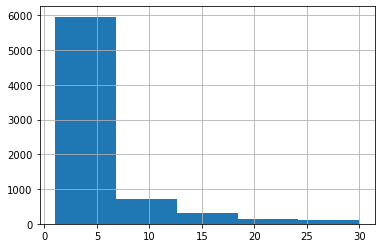

In [31]:
ther['duration'].hist(bins=5,range=(1,30))

<AxesSubplot:>

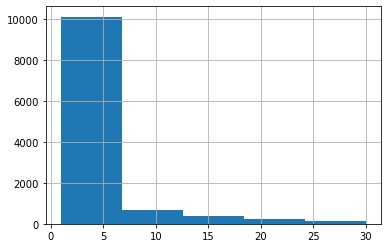

In [32]:
duty['duration'].hist(bins=5,range=(1,30))

В случае терапевтов по записи наблюдается чуть больше более продолжительных кейсов (6-13 дней) по сравнению с дежурными врачами.

### Распределение основных количественных показателей

Изучим распределение убытков.

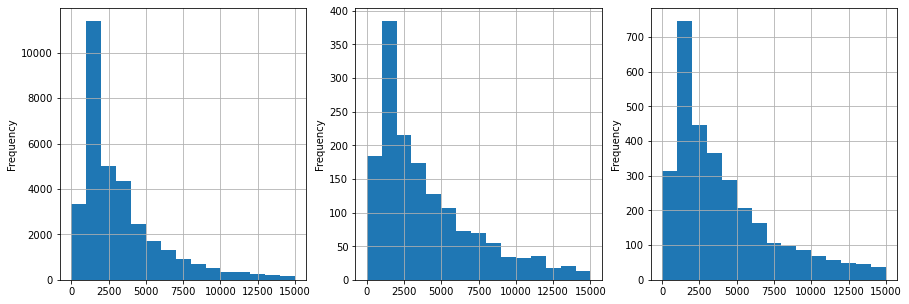

In [33]:
for j, df in enumerate([data_offline,ther[~ther['is_free']],duty[~duty['is_free']]]):
    df['loss'].plot(kind='hist',
                                           grid=True,
                                           figsize=(15, 5),
                                           bins=15,range=(1,15000),
                                           ax=plt.subplot(1,3,j+1))
plt.show()

Распределение убытков по кейсам терапевтов под запись и дежурных врачей в целом выглядят одинаково. Незначительно выделяется количество дешёвых кейсов (меньше 1000 рублей) у дежурных терапевтов - их чуть меньше чем у терапевтов под запись.

Изучим распределение убытков с разбивкой по регионам.

Регионы


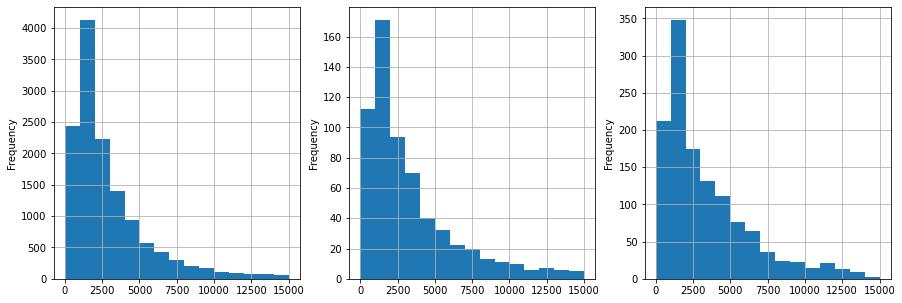

Санкт-Петербург


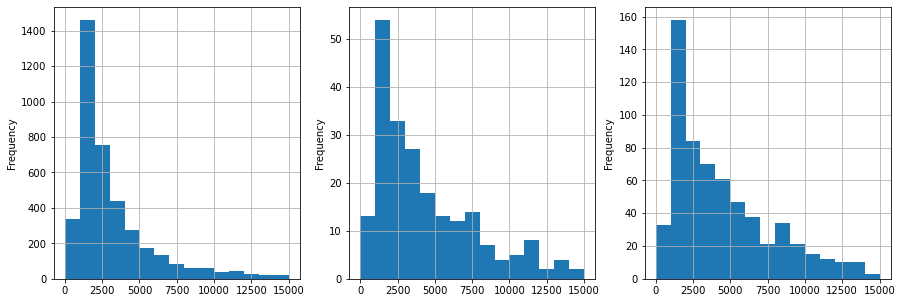

Москва


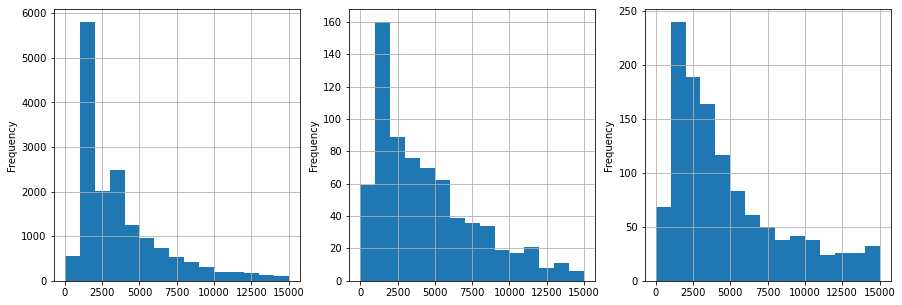

In [34]:
for i in df['region'].unique():
    print(i)
    for j, df in enumerate([data_offline,ther[~ther['is_free']],duty[~duty['is_free']]]):
        df[(df['region']==i)]['loss'].plot(kind='hist',
                                           grid=True,
                                           figsize=(15, 5),
                                           bins=15,range=(1,15000),
                                           ax=plt.subplot(1,3,j+1))
    plt.show()

Распределения регионов и Санкт-Петербурга по всем категориям кейсов выглядят примерно одинаково. А вот в случае Москвы выделяются кейсы дежурных терапевтов - доля дешевых кейсов (меньше 1000 рублей) ниже чем у терапевтов под запись. А доля дорогих кейсов (более 2000 рублей) выше. 

Изучим распределение убытков с разбивкой по профилям.

Терапия


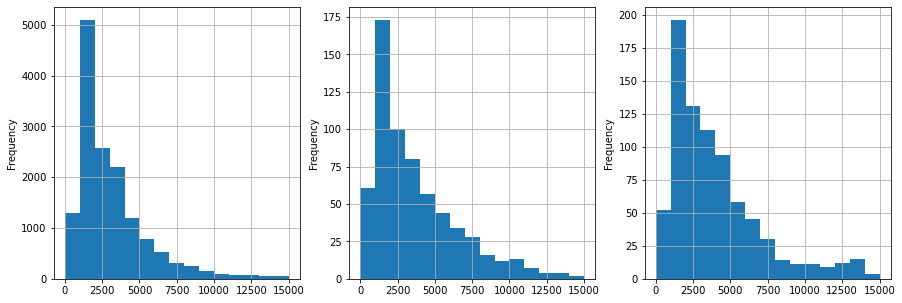

Неврология


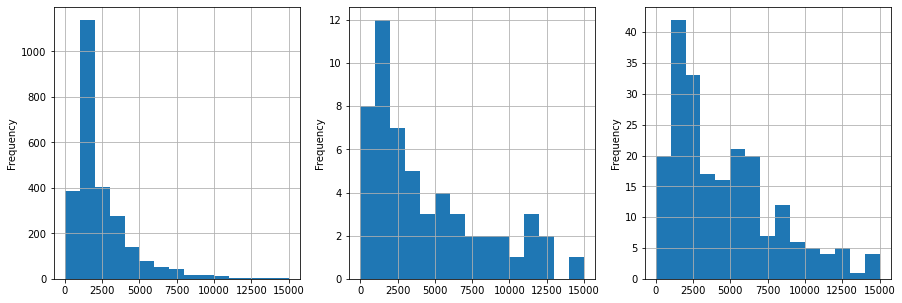

Травматология


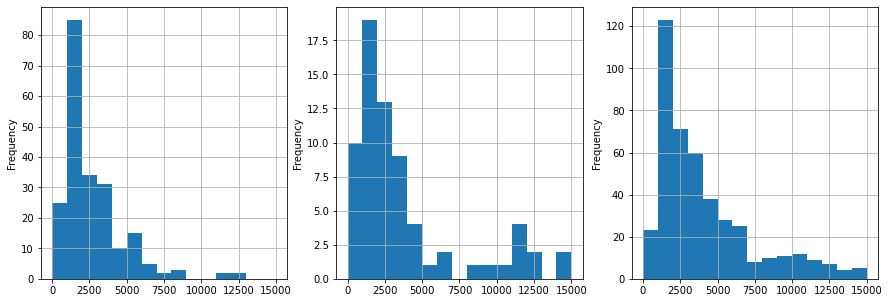

Инфекции


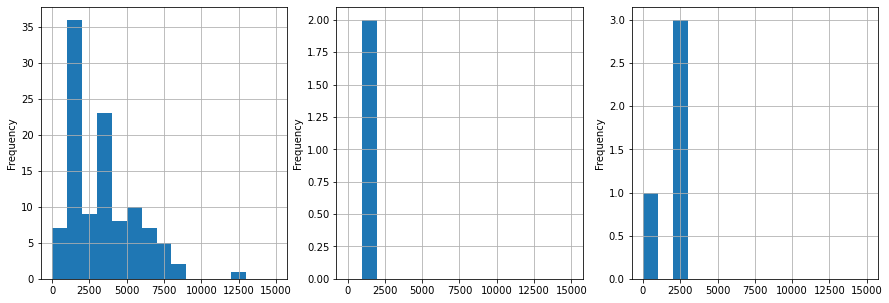

Unknown


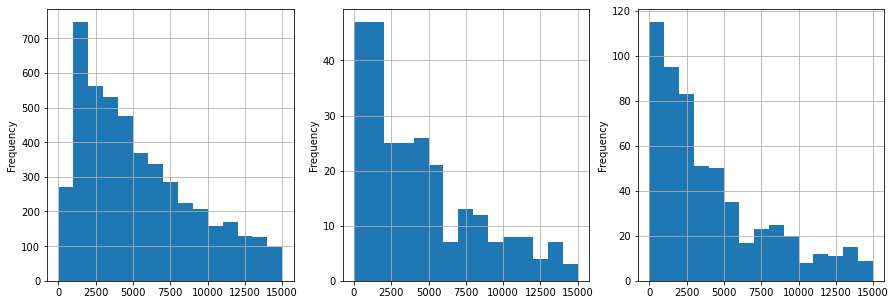

Урология


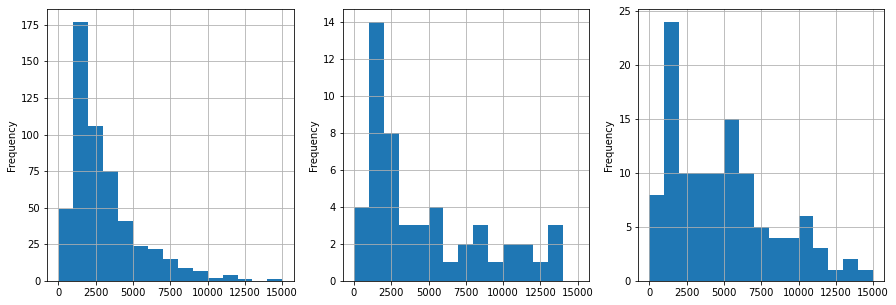

Аллергология-иммунология


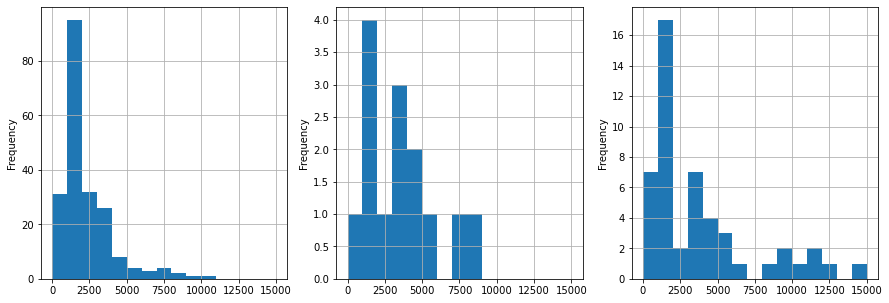

Эндокринология


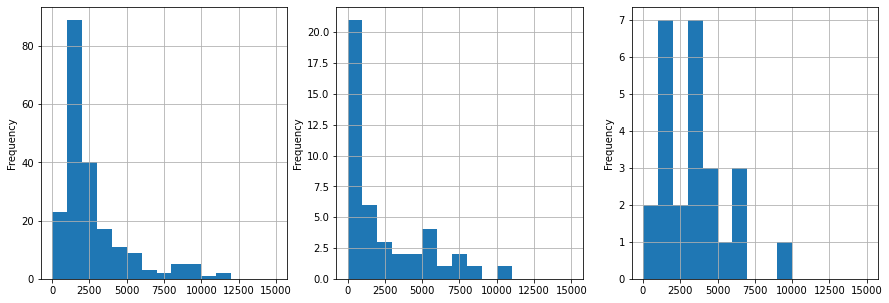

Кардиология


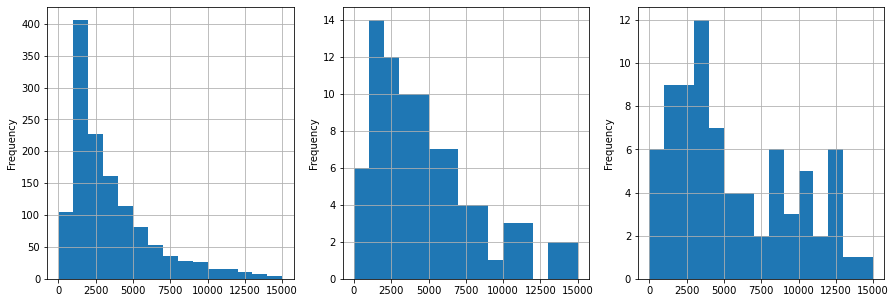

Хирургия


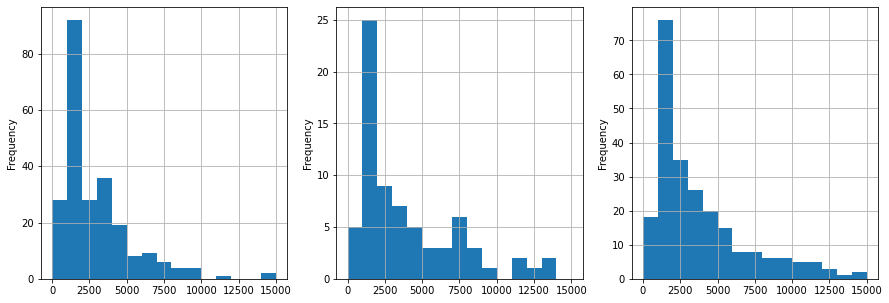

Гастроэнтерология


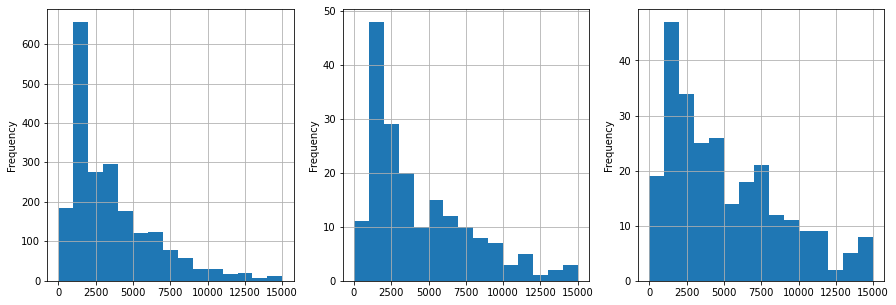

Гинекология


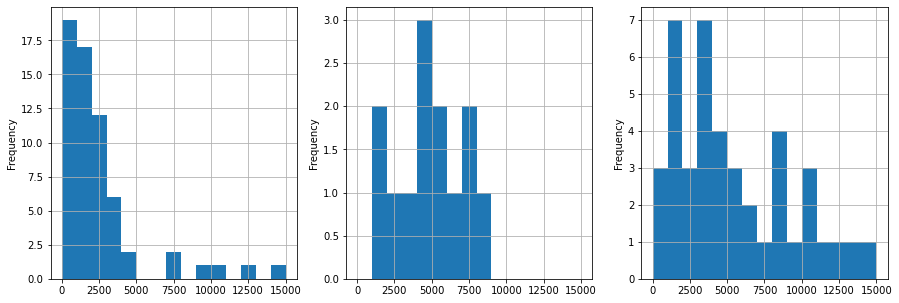

Дерматология


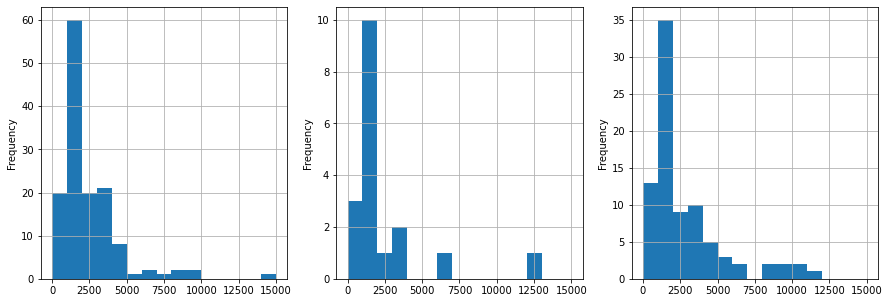

Нет


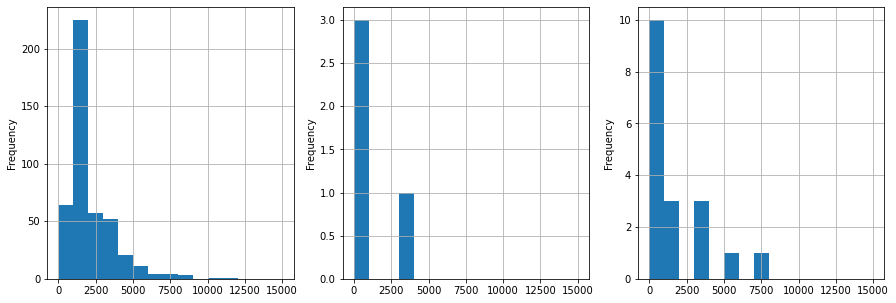

Отоларингология (ЛОР)


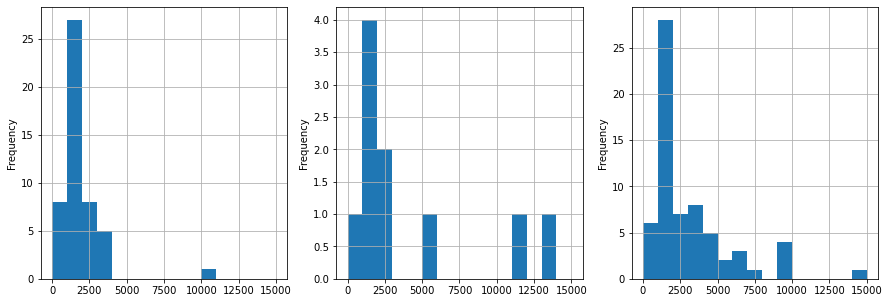

Психиатрия


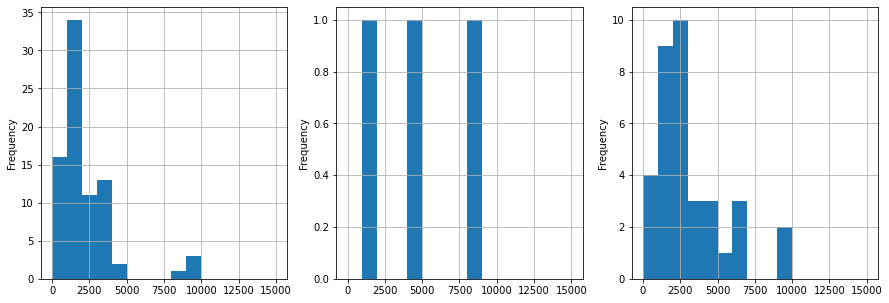

Офтальмология


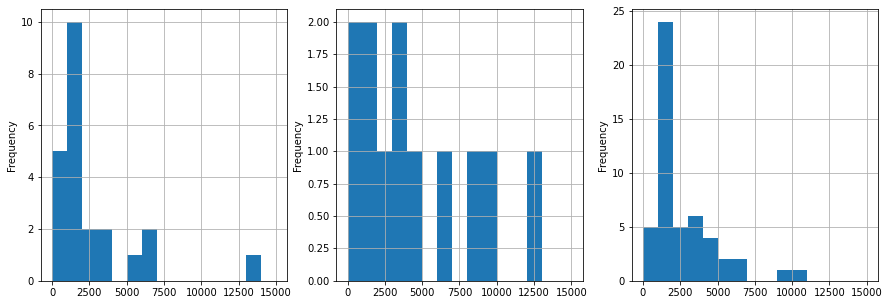

Ревматология


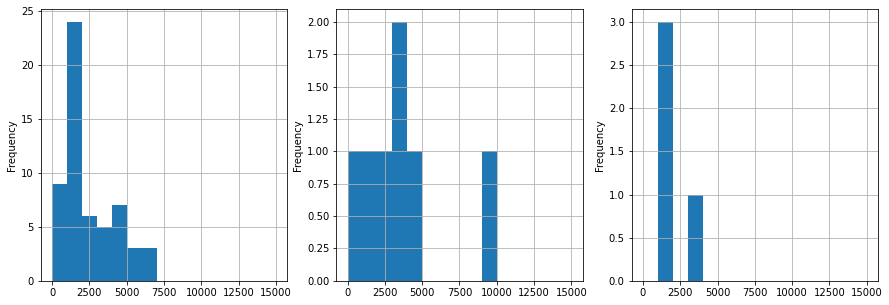

Стоматология


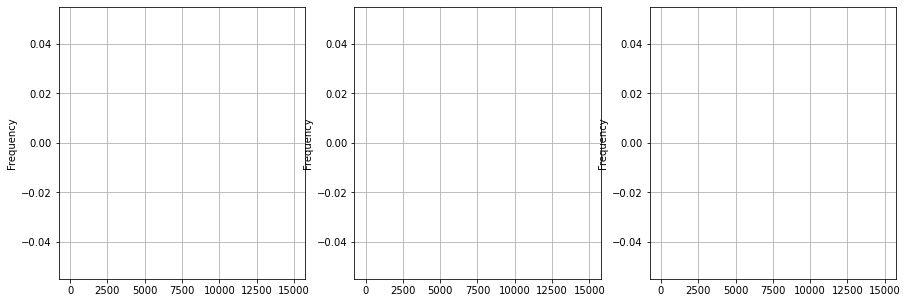

Гематология


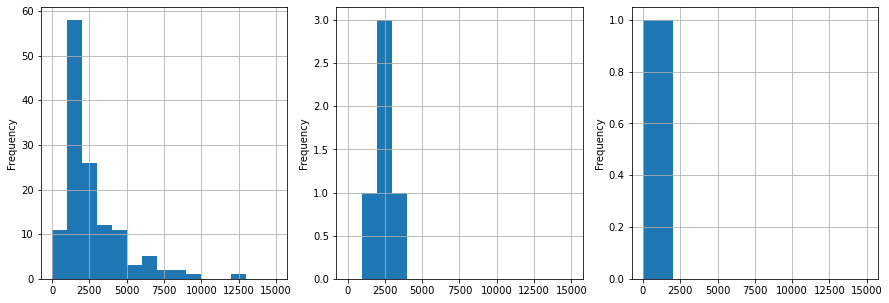

In [35]:
for i in data_online['profile'].unique():
    print(i)
    for j, df in enumerate([data_offline,ther[~ther['is_free']],duty[~duty['is_free']]]):
        df[(df['profile']==i)]['loss'].plot(kind='hist',
                                           grid=True,
                                           figsize=(15, 5),
                                           bins=15,range=(1,15000),
                                           ax=plt.subplot(1,3,j+1))
    plt.show()

Изучим распределение убытков с разбивкой по категориям.

Только телемед без оффлайн


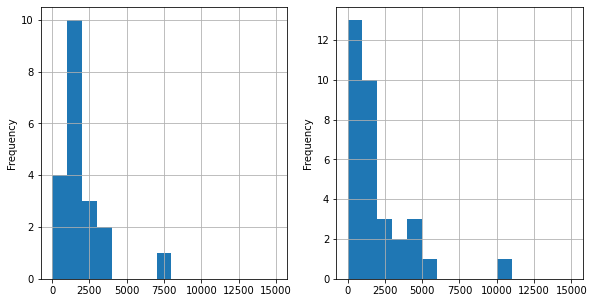

Телемед+оффлайн прием


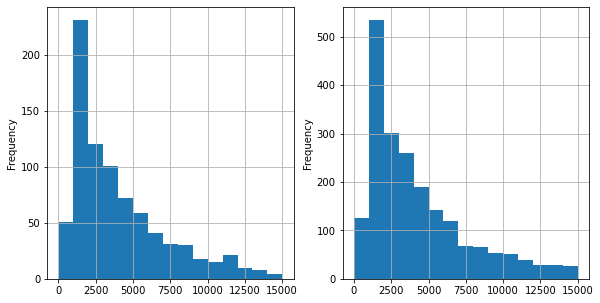

Оффлайн прием+телемед


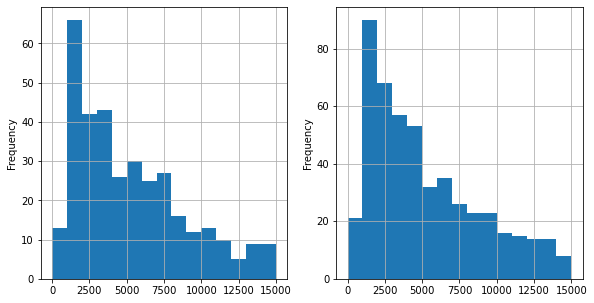

Телемед+оффлайн без приема


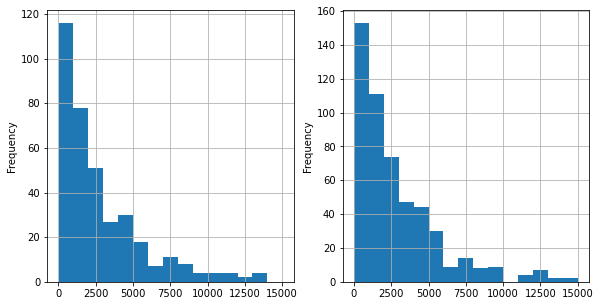

In [36]:
for i in data_online['category'].unique():
    print(i)
    for j, df in enumerate([ther[~ther['is_free']],duty[~duty['is_free']]]):
        df[(df['category']==i)]['loss'].plot(kind='hist',
                                           grid=True,
                                           figsize=(15, 5),
                                           bins=15,range=(1,15000),
                                           ax=plt.subplot(1,3,j+1))
    plt.show()

1. Во-первых, непонятно, что представляют собой убытки в категории "Только телемед".
2. Дежурные терапевты опять показывают более объёмную долю дорогих кейсов (более 2000 рублей) в случае "Оффлайн-прием + телемед".
3. Распределения категорий "Телемед+оффлайн прием" и "Телемед+оффлайн без приема" примерно одинаковы.

Кейсы "Только телемед" с убытками:

In [37]:
data_online[~data_online['is_free']&(data_online['category']=='Только телемед без оффлайн')]

,unique_case_id,patient_id,doctor_specialty_online,start_case,region,profile,category,duration,loss,telemed_cnt,analysis_cnt,offline_cnt,vnd_cnt,hospital_cnt,unknown_cnt,is_free
134,100870&Урология&0,100870,Терапевт,2021-01-27,Регионы,Урология,Только телемед без оффлайн,6,1150.0,2,0,0,0,0,0,False
387,103498&&0,103498,Врач общей практики,2021-06-14,Регионы,Unknown,Только телемед без оффлайн,68,2520.0,1,0,0,0,0,0,False
505,104576&Нет&0,104576,Врач общей практики,2021-08-02,Регионы,Нет,Только телемед без оффлайн,180,200.0,1,0,0,0,0,1,False
655,105905&Аллергология-иммунология&0,105905,Врач общей практики,2021-07-28,Регионы,Аллергология-иммунология,Только телемед без оффлайн,18,1000.0,1,0,0,0,0,0,False
839,107324&Аллергология-иммунология&0,107324,Терапевт,2021-07-14,Регионы,Аллергология-иммунология,Только телемед без оффлайн,16,770.0,1,0,0,0,0,0,False
967,108013&Травматология&1,108013,Врач общей практики,2022-01-21,Регионы,Травматология,Только телемед без оффлайн,35,5600.0,1,0,0,0,0,2,False
996,108205&&0,108205,Терапевт,2022-02-28,Регионы,Unknown,Только телемед без оффлайн,10,1200.0,3,0,0,0,0,0,False
1034,108485&Хирургия&0,108485,Врач общей практики,2021-10-25,Регионы,Хирургия,Только телемед без оффлайн,10,2000.0,1,0,0,0,0,1,False
1438,111287&Офтальмология&2,111287,Врач общей практики,2022-05-29,Регионы,Офтальмология,Только телемед без оффлайн,7,1080.0,2,0,0,0,0,1,False
1923,114563&Кардиология&1,114563,Терапевт,2021-06-24,Регионы,Кардиология,Только телемед без оффлайн,9,800.0,3,0,0,0,0,0,False


Посмотрим, есть ли корреляция между продолжительностью и убытками кейсов.

<AxesSubplot:xlabel='loss', ylabel='duration'>

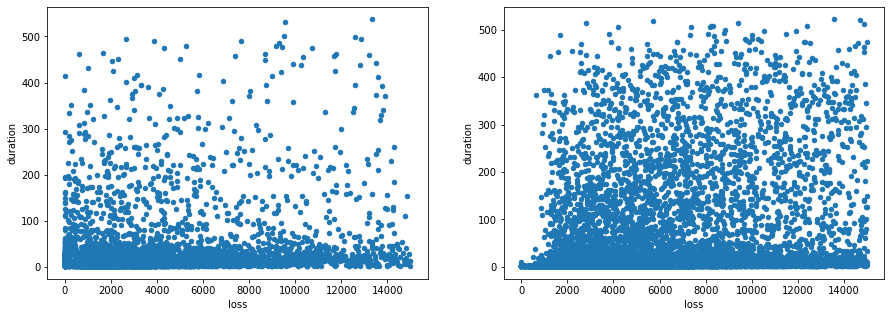

In [38]:
data_online.plot(x='loss', y='duration', kind='scatter',figsize=(15,5),ax=plt.subplot(1,2,1))
data_offline.plot(x='loss', y='duration', kind='scatter',ax=plt.subplot(1,2,2))

In [39]:
data_online['loss'].corr(data_online['duration'])

0.39957884388198994

In [40]:
data_offline['loss'].corr(data_offline['duration'])

0.3916960871330832

В онлайн-кейсах линейная зависимость прослеживается, но слабая. В оффлайн-кейсах зависимость ещё слабее.

<AxesSubplot:xlabel='loss', ylabel='offline_cnt'>

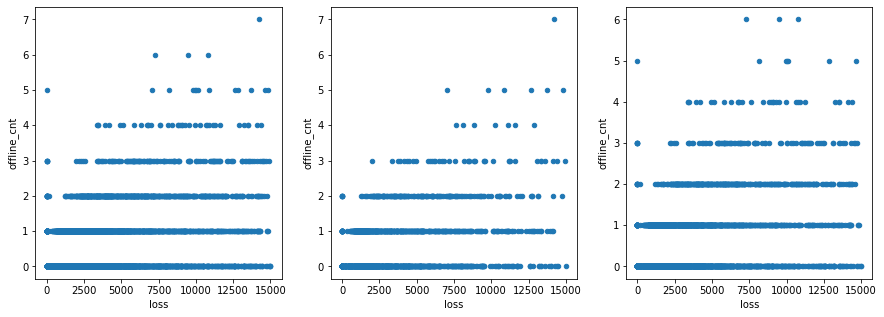

In [41]:
data_online.plot(x='loss', y='offline_cnt', kind='scatter',figsize=(15,5),ax=plt.subplot(1,3,1))
ther.plot(x='loss', y='offline_cnt', kind='scatter',figsize=(15,5),ax=plt.subplot(1,3,2))
duty.plot(x='loss', y='offline_cnt', kind='scatter',figsize=(15,5),ax=plt.subplot(1,3,3))

In [42]:
data_online['loss'].corr(data_online['offline_cnt'])

0.5972368970379395

<AxesSubplot:xlabel='loss', ylabel='analysis_cnt'>

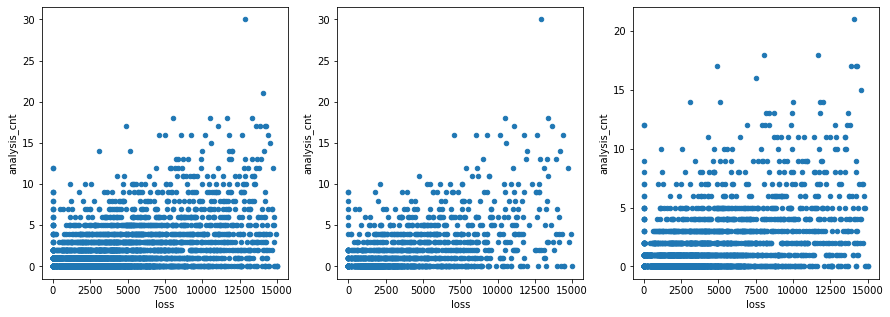

In [43]:
data_online.plot(x='loss', y='analysis_cnt', kind='scatter',figsize=(15,5),ax=plt.subplot(1,3,1))
ther.plot(x='loss', y='analysis_cnt', kind='scatter',figsize=(15,5),ax=plt.subplot(1,3,2))
duty.plot(x='loss', y='analysis_cnt', kind='scatter',figsize=(15,5),ax=plt.subplot(1,3,3))

In [44]:
data_online['loss'].corr(data_online['analysis_cnt'])

0.63730959951118

Зато существует достаточно явно прослеживается линейная зависимость между количеством приёмов, количеством анализов и манипуляций и убытками в онлайн-кейсах.

## Статистический анализ

Проведём статистический анализ и проверим две гипотезы:
1. Действительно ли средний чек терапевтов по записи меньше среднего чека дежурных врачей.
2. Возможно, на данные выборки влияет геолокация пациентов - проверим гипотезу в разрезе пациентов Москвы.

### Гипотеза 1

Проверим, различается ли средний чек пациентов терапевтов по записи и дежурных врачей.

Сформулируем **нулевую гипотезу**.

    H₀: Средний чек у пациентов терапевтов по записи и дежурных врачей одинаков.

**Альтерантивная гипотеза**.
    
    H₁: Средний чек у пациентов терапевтов по записи меньше среднего чека дежурных врачей.
    
Проверим, следует ли отклонять нулевую гипотезу - проведём Т-тест для независимых выборок.

В качестве значения уровня статистической значимости возьмём 5%.

In [45]:
print('Количество кейсов Терапевтов:',ther[~ther['is_free']]['loss'].count())
print('Средний чек:',ther[~ther['is_free']]['loss'].mean())
print('Выборочная дисперсия:',numpy.var(ther[~ther['is_free']]['loss'], ddof=1))
print('Выборочное стандартное отклонение:',numpy.std(ther[~ther['is_free']]['loss'], ddof=1))
print()
print('Количество кейсов Дежурных:',duty[~duty['is_free']]['loss'].count())
print('Средний чек:',duty[~duty['is_free']]['loss'].mean())
print('Выборочная дисперсия:',numpy.var(duty[~duty['is_free']]['loss'], ddof=1))
print('Выборочное стандартное отклонение:',numpy.std(duty[~duty['is_free']]['loss'], ddof=1))
print()

Количество кейсов Терапевтов: 1542
Средний чек: 4006.2656225680953
Выборочная дисперсия: 10771805.3238493
Выборочное стандартное отклонение: 3282.042858319998

Количество кейсов Дежурных: 3074
Средний чек: 4161.3325569290855
Выборочная дисперсия: 11190373.648142371
Выборочное стандартное отклонение: 3345.201585576327



In [46]:
from scipy import stats as st
alpha = .05 # уровень статистической значимости

results = st.ttest_ind(
    ther[~ther['is_free']]['loss'],
    duty[~duty['is_free']]['loss'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.13503070205608927
Не отвергаем нулевую гипотезу


Отвергнуть нулевую гипотезу не удалось. Значит, мы не можем утверждать, что средние чеки отличаются.

### Гипотеза 2

Проверим, различается ли средний чек пациентов терапевтов по записи и дежурных врачей в Москве.

Сформулируем **нулевую гипотезу**.

    H₀: Средний чек у пациентов терапевтов по записи и дежурных врачей в Москве одинаков.

**Альтерантивная гипотеза**.
    
    H₁: Средний чек у пациентов терапевтов по записи в Москве меньше среднего чека дежурных врачей.
    
Проверим, следует ли отклонять нулевую гипотезу - проведём Т-тест для независимых выборок.

В качестве значения уровня статистической значимости возьмём 5%.

In [47]:
print('Количество кейсов Терапевтов в Москве:',ther[(~ther['is_free'])&(ther['region']=='Москва')]['loss'].count())
print('Средний чек:',ther[(~ther['is_free'])&(ther['region']=='Москва')]['loss'].mean())
print('Выборочная дисперсия:',numpy.var(ther[(~ther['is_free'])&(ther['region']=='Москва')]['loss'], ddof=1))
print('Выборочное стандартное отклонение:',numpy.std(ther[(~ther['is_free'])&(ther['region']=='Москва')]['loss'], ddof=1))
print()
print('Количество кейсов Дежурных в Москве:',duty[(~duty['is_free'])&(duty['region']=='Москва')]['loss'].count())
print('Средний чек:',duty[(~duty['is_free'])&(duty['region']=='Москва')]['loss'].mean())
print('Выборочная дисперсия:',numpy.var(duty[(~duty['is_free'])&(duty['region']=='Москва')]['loss'], ddof=1))
print('Выборочное стандартное отклонение:',numpy.std(duty[(~duty['is_free'])&(duty['region']=='Москва')]['loss'], ddof=1))
print()

Количество кейсов Терапевтов в Москве: 707
Средний чек: 4453.216251768034
Выборочная дисперсия: 11312582.468522059
Выборочное стандартное отклонение: 3363.4182714200233

Количество кейсов Дежурных в Москве: 1198
Средний чек: 4792.222362270452
Выборочная дисперсия: 13353027.554811902
Выборочное стандартное отклонение: 3654.1794639579352



In [48]:
from scipy import stats as st
alpha = .05 # уровень статистической значимости

results = st.ttest_ind(
    ther[(~ther['is_free'])&(ther['region']=='Москва')]['loss'],
    duty[(~duty['is_free'])&(duty['region']=='Москва')]['loss'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.04413943375084426
Отвергаем нулевую гипотезу


Наши наблюдения исследовательского анализа подтвердились - средние чеки по дежурным и терапевтам в Москве действительно отличаются.

### Гипотеза 3

Проверим, различается ли средний чек пациентов терапевтов по записи и дежурных врачей в Москве.

Сформулируем **нулевую гипотезу**.

    H₀: Средняя длительность кейсов у пациентов терапевтов по записи и дежурных врачей в Москве одинакова.

**Альтерантивная гипотеза**.
    
    H₁: Средняя длительность кейсов у пациентов терапевтов по записи в Москве больше средней длительности кейсов дежурных врачей.
    
Проверим, следует ли отклонять нулевую гипотезу - проведём Т-тест для независимых выборок.

В качестве значения уровня статистической значимости возьмём 5%.

In [51]:
print('Количество кейсов Терапевтов в Москве:',ther['duration'].count())
print('Средняя длительность:',ther['duration'].mean())
print('Выборочная дисперсия:',numpy.var(ther['duration'], ddof=1))
print('Выборочное стандартное отклонение:',numpy.std(ther['duration'], ddof=1))
print()
print('Количество кейсов Дежурных в Москве:',duty['duration'].count())
print('Средняя длительность:',duty['duration'].mean())
print('Выборочная дисперсия:',numpy.var(duty['duration'], ddof=1))
print('Выборочное стандартное отклонение:',numpy.std(duty['duration'], ddof=1))
print()

Количество кейсов Терапевтов в Москве: 7583
Средняя длительность: 9.175524198865885
Выборочная дисперсия: 1227.382930267974
Выборочное стандартное отклонение: 35.03402532207759

Количество кейсов Дежурных в Москве: 12252
Средняя длительность: 10.23073783872021
Выборочная дисперсия: 1559.7262839058062
Выборочное стандартное отклонение: 39.493370125956666



In [52]:
alpha = .05 # уровень статистической значимости

results = st.ttest_ind(
    ther['duration'],
    duty['duration'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.056407770380606896
Не отвергаем нулевую гипотезу


## Вывод

Итак, в ходе проекта мы:
- получили данные по оффлайн- и онлайн-кейсам;
- осмотрели данные на предмет пропусков, исправили типы данных в столбцах с датами на корректные;
- разделили онлайн-кейсы на кейсы дежурных терапевтов и кейсы терапевтов под запись;
- провели исследовательский анализ, изучили характеристики положения данных и выяснили, что:
        - убытки по платным онлайн-кейсам выше убытков оффлайн-кейсов;
        - онлайн-кейсы менее длительные (11 дней) чем оффлайн-кейсы (18 дней);
        - у терапевтов по записи доля бесплатных кейсов больше чем у дежурных врачей.
- проверили выдвинутые гипотезы на статистических тестах и сделали вывод, что, несмотря на некоторые отличия, однозначно опровергнуть однородность платных кейсов терапевтов по записи и дежурных терапевтов нельзя, однако для пациентов Москвы средний чек у дежурных терапевтов выше, чем у терапевтов по записи. 
- таким образом, **терапевты по записи выглядят более эффективными по сравнению с дежурными врачами - их кейсы короче, доля бесплатнеых кейсов выше на 5%, а платные кейсы приносят меньше убытков, что особенно сильно прослеживается в Москве.**